In [104]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
from Stage1.GAT.GATModel import GraphAttentionNetwork
import torch
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import normalise_text
from pathlib import Path
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
REMOVE_DUPES = False

In [2]:
# Load model
# model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
# state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model = GraphAttentionNetwork(in_dim = 119, pe_dim=11, edge_in_dim = 210, edge_emb_dim = 32, heads = 4)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/TrueTransformer-newtagsnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

GraphAttentionNetwork(
  (pe_lin): Linear(in_features=18, out_features=11, bias=True)
  (pe_norm): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0-5): 6 x GPSConv(112, conv=GINEConv(nn=Sequential(
      (0): Linear(in_features=112, out_features=112, bias=True)
      (1): ReLU()
      (2): Linear(in_features=112, out_features=112, bias=True)
    )), heads=4, attn_type=multihead)
  )
  (edge_mlp): Sequential(
    (0): Linear(in_features=256, out_features=112, bias=True)
    (1): ReLU()
    (2): Linear(in_features=112, out_features=1, bias=True)
  )
  (title_head): Sequential(
    (0): Linear(in_features=112, out_features=112, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=112, out_features=1, bias=True)
  )
)

In [ ]:
SRC_FOLDER = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)")
SRC_GRAPHS = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/allmovie")

html_files = sorted(list(SRC_FOLDER.rglob("*.htm")), key=lambda p: str(p)[-8:-4])
graph_folders = sorted([f for f in SRC_GRAPHS.iterdir() if f.is_dir()], key=lambda p: str(p)[-4:])
print(html_files)
print(graph_folders)
for file, graph in zip(html_files, graph_folders):
    sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted, title_label, title_txt, title_xpaths, title_probs = txtExtractor(str(file), model, alreadyConvertedToGraph=str(graph), remove_dupes=REMOVE_DUPES)
    np.save(graph/"sorted_label_index.npy",sorted_label_index_extracted)
    np.save(graph/"xpaths.npy",xpaths_extracted)
    np.save(graph/"txts.npy",txts_extracted)
    np.save(graph/"probs.npy",probs_extracted)
    np.save(graph/"title_label.npy",title_label)
    np.save(graph/"title_txt.npy",title_txt)
    np.save(graph/"title_probs.npy",title_probs)
    print("saved: ", graph)

[PosixPath('/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm'), PosixPath('/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0001.htm'), PosixPath('/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0002.htm'), PosixPath('/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0003.htm'), PosixPath('/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0004.htm'), PosixPath('/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0005.htm'), PosixPath('/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0006.htm'), PosixPath('/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0007.htm'), PosixPath('/vol/bitbucket/mjh24

: 

In [109]:
SRC_GRAPHS = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/allmovie")
with open("/vol/bitbucket/mjh24/IAEA-thesis/data/swde_expanded_dataset/dataset/movie/movie-allmovie(2000).json") as f:
    labels = json.load(f)

clusteringfilter = "Post_clustering_filter"

TESTINGFILTER = clusteringfilter

graph_folders = sorted([f/TESTINGFILTER for f in SRC_GRAPHS.iterdir() if f.is_dir()], key=lambda p: str(p)[-len(TESTINGFILTER)-5:-len(TESTINGFILTER)-1])
folder_map = {str(f)[-len(TESTINGFILTER)-5:-len(TESTINGFILTER)-1] + ".htm": f for f in graph_folders}

results = {}
list_of_k = []
SimilarWorks = {"Is featured in:",
"Is preceded by:",
"Influenced:",
"Is followed by:" ,
"Is spoofed in:" ,
"Has been remade as:",
"Is a version of:",
"Is influenced by:" ,
"Is re-edited from:" ,
"Has been re-edited into:",
"Is a spoof of:",
"Is related to:"}

# assume `data` is the JSON you loaded with json.load(file)
for parent_key, attributes in labels.items():
    with open(folder_map[parent_key]/"TEXT_CLUSTERS.pkl", 'rb') as f:
        edges = pickle.load(f)
    print("Loaded: ", parent_key)
    
    results[parent_key] = {}

    for attr_key, values in attributes.items():
        attr_key = attr_key.split("|")[-1].strip()
        for value in values:
            count = 0
            found = False
            for cluster in edges:
                if normalise_text(value) in normalise_text(" ".join(cluster)):
                    count += 1
                    if normalise_text(attr_key) in normalise_text(" ".join(cluster)):
                        found = True
                        break
            if found:
                results[parent_key][(attr_key, value)] = count
                list_of_k.append(count)
            else:
                print((attr_key, value), "not found")
                results[parent_key][(attr_key, value)] = -1
                list_of_k.append(-1)

Loaded:  0000.htm
('Category', 'Feature') not found
('topic_entity_name', 'The Sweet Hereafter') not found
Loaded:  0001.htm
('Category', 'Feature') not found
('Countries', 'France') not found
('topic_entity_name', 'Breaking the Waves') not found
Loaded:  0002.htm
('Category', 'Feature') not found
('topic_entity_name', 'Dead Man Walking') not found
Loaded:  0003.htm
('Category', 'Feature') not found
('Countries', 'France') not found
('Is preceded by:', 'White') not found
('topic_entity_name', 'Red') not found
Loaded:  0004.htm
('Category', 'Feature') not found
('topic_entity_name', 'Chungking Express') not found
Loaded:  0005.htm
('Category', 'Feature') not found
('Keywords', 'extramarital-affair') not found
('Keywords', 'barnstorming') not found
('Keywords', 'alcoholism') not found
('Keywords', 'destruction') not found
('Keywords', 'argument') not found
('Keywords', 'artist') not found
('Keywords', 'baker') not found
('Keywords', 'big-city') not found
('Keywords', 'clown') not found
(

In [110]:
json_ready = {
    parent: {f"{k[0]} || {k[1]}": v for k, v in kvs.items()}
    for parent, kvs in results.items()
}

with open("./postclusterresults.json", "w") as f: #commenting out so cannot accidentally be overwritten
   json.dump(json_ready, f, indent=4)


In [ ]:
SRC_GRAPHS = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/allmovie")
graph_folders = sorted([f for f in SRC_GRAPHS.iterdir() if f.is_dir()], key=lambda p: str(p)[-4:])
with open("/vol/bitbucket/mjh24/IAEA-thesis/data/swde_expanded_dataset/dataset/movie/movie-allmovie(2000).json") as f:
    labels = json.load(f)
with open("./postclusterresults.json", "r") as f:
    results = json.load(f)
#folder_map = {str(f)[-4:] + ".htm": f for f in graph_folders}

In [98]:
orig = []
new = []
for i, (parent_key, attributes) in enumerate(labels.items()):
    if i < 1000:
        continue
    title_txt = np.load(folder_map[parent_key]/"title_txt.npy")
    node_txt = np.load(folder_map[parent_key]/"Post_button_filter/node_unique_txts.npy")
    orig.append(len(title_txt))
    new.append(len(node_txt))
orig, new = np.array(orig), np.array(new)

In [99]:
low_prob = []
for i, (parent_key, attributes) in enumerate(labels.items()):
    if i < 1000:
        continue
    node_txt = np.load(folder_map[parent_key]/"Post_low_prop_filter/txts.npy")
    low_prob.append(len(node_txt))
low_prob = np.array(low_prob)

In [101]:
seman = []
for i, (parent_key, attributes) in enumerate(labels.items()):
    if i < 1000:
        continue
    node_txt = np.load(folder_map[parent_key]/"Post_semantics_filter/txts.npy")
    seman.append(len(node_txt))
seman = np.array(seman)

In [103]:
print(np.mean(low_prob-seman))
print(np.mean(low_prob))
print(np.mean(seman))

12.331
267.703
255.372


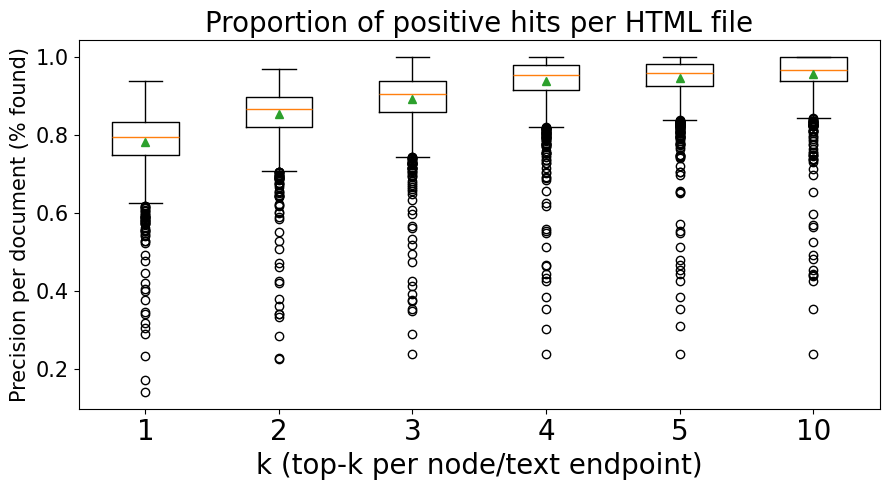

In [28]:
# Count the % correct in a document for the 2000 documents (Recall per document)
distributions = []
ks = [1,2,3,4,5,10]
for k in ks:
    percentages = []
    for parent_key, kv_pairs in results.items():
        counts = kv_pairs.values()  # all the count numbers for this page
        total = len(counts)-1
        if total == 0:
            percentages.append(0.0)  # avoid division by zero
            continue

        # how many counts are in [0, 5]
        correct = sum(1 for c in counts if 0 < c <= k)

        # percentage for this page
        percentages.append(correct / total)
    
    distributions.append(percentages)


plt.figure(figsize=(9, 5))
plt.boxplot(distributions, tick_labels=[str(k) for k in ks], showmeans=True)
plt.xlabel("k (top-k per node/text endpoint)", fontdict={"fontsize":20})
plt.ylabel(r"Precision per document (% found)", fontdict={"fontsize":15})
plt.title("Proportion of positive hits per HTML file", fontdict={"fontsize":20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

[0.7657714043775197, 0.8318760009572372, 0.8689689450140824, 0.9153765440053017, 0.9223349225926403, 0.9332971301290429]


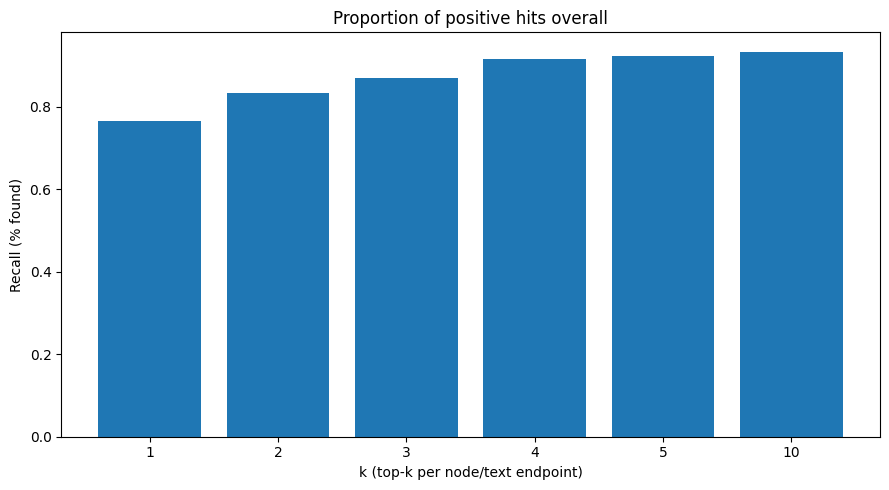

In [29]:
# Number of hits in k for all 2000*200 edges

all_counts = []
bars = []

for kv_pairs in results.values():
    for c in kv_pairs.values():
        all_counts.append(c)
for k in ks:
    hits = sum(1 for c in all_counts if 0 < c <= k)
    proportion = hits / len(all_counts)
    bars.append(proportion)
print(bars)
plt.figure(figsize=(9, 5))
plt.bar([str(k) for k in ks], bars)
plt.xlabel("k (top-k per node/text endpoint)")
plt.ylabel(r"Recall (% found)")
plt.title("Proportion of positive hits overall")
plt.tight_layout()
plt.show()

In [8]:
#Get the top k edges per node. Then test the prospective edges 1=edge can be found. 2=edge cannot be found. Therefore this gives n F1 score that can be used. 
TP = sum(1 for c in all_counts if 0 < c <= 1)
FN = sum(1 for c in all_counts if c != 1) - 2000 # -2000 to ignore not found as will be skewed by "topic_entity"

SRC_GRAPHS = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/allmovie")
with open("/vol/bitbucket/mjh24/IAEA-thesis/data/swde_expanded_dataset/dataset/movie/movie-allmovie(2000).json") as f:
    labels = json.load(f)

graph_folders = sorted([f for f in SRC_GRAPHS.iterdir() if f.is_dir()], key=lambda p: str(p)[-4:])
folder_map = {str(f)[-4:] + ".htm": f for f in graph_folders}

FP = 0
TN = 0

for parent_key, attributes in labels.items():
    graph = folder_map[parent_key]
    edges = np.load(graph / "txts.npy")
    print("Loaded: ", parent_key)

    # Build a reverse lookup: value -> correct keys
    value_to_keys = {}
    for k, vals in attributes.items():
        for v in vals:
            value_to_keys.setdefault(v, set()).add(normalise_text(k))

    seen_right = set()

    for src, tgt in edges:
        # correct keys for this tgt (empty if tgt not in labels)
        correct_keys = value_to_keys.get(tgt, set())

        if tgt in value_to_keys and tgt not in seen_right:
            seen_right.add(tgt)
            # FP if left side is not the exact correct key
            if normalise_text(src) not in correct_keys:
                FP += 1
        else:
            # subsequent times → TN 
            if tgt in value_to_keys and normalise_text(src) not in correct_keys:
                TN += 1
                
print(TP, TN, FP, FN)

Loaded:  0000.htm
Loaded:  0001.htm
Loaded:  0002.htm
Loaded:  0003.htm
Loaded:  0004.htm
Loaded:  0005.htm
Loaded:  0006.htm
Loaded:  0007.htm
Loaded:  0008.htm
Loaded:  0009.htm
Loaded:  0010.htm
Loaded:  0011.htm
Loaded:  0012.htm
Loaded:  0013.htm
Loaded:  0014.htm
Loaded:  0015.htm
Loaded:  0016.htm
Loaded:  0017.htm
Loaded:  0018.htm
Loaded:  0019.htm
Loaded:  0020.htm
Loaded:  0021.htm
Loaded:  0022.htm
Loaded:  0023.htm
Loaded:  0024.htm
Loaded:  0025.htm
Loaded:  0026.htm
Loaded:  0027.htm
Loaded:  0028.htm
Loaded:  0029.htm
Loaded:  0030.htm
Loaded:  0031.htm
Loaded:  0032.htm
Loaded:  0033.htm
Loaded:  0034.htm
Loaded:  0035.htm
Loaded:  0036.htm
Loaded:  0037.htm
Loaded:  0038.htm
Loaded:  0039.htm
Loaded:  0040.htm
Loaded:  0041.htm
Loaded:  0042.htm
Loaded:  0043.htm
Loaded:  0044.htm
Loaded:  0045.htm
Loaded:  0046.htm
Loaded:  0047.htm
Loaded:  0048.htm
Loaded:  0049.htm
Loaded:  0050.htm
Loaded:  0051.htm
Loaded:  0052.htm
Loaded:  0053.htm
Loaded:  0054.htm
Loaded:  0

In [9]:
# Precision:  0.807973551948587
# Recall:  0.7364009274121633
# Accuracy:  0.9950741995666535
# F1:  0.7705287557273277

print("Precision: ", TP/(TP+FP))
print("Recall: ", TP/(TP+FN))
print("Accuracy: ", (TP+TN)/(TP+FN+TN+FP)) #TN is large. Massive class imbalance makes this look much better than it is
print("F1: ", 2*(TP/(TP+FP))*(TP/(TP+FN))/((TP/(TP+FP))+(TP/(TP+FN))))

Precision:  0.816924089039011
Recall:  0.7801324006526265
Accuracy:  0.9955627528452387
F1:  0.7981044563502152


In [36]:
# This is the same as above, but the FP are not restricted to those values we expect to see. They are ALL the positive edges the model predicts BUT note that this is before pruning
TP = sum(1 for c in all_counts if 0 < c <= 1)
FN = sum(1 for c in all_counts if c != 1) - 2000

SRC_GRAPHS = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/allmovie")
with open("/vol/bitbucket/mjh24/IAEA-thesis/data/swde_expanded_dataset/dataset/movie/movie-allmovie(2000).json") as f:
    labels = json.load(f)

graph_folders = sorted([f for f in SRC_GRAPHS.iterdir() if f.is_dir()], key=lambda p: str(p)[-4:])
folder_map = {str(f)[-4:] + ".htm": f for f in graph_folders}

FP = 0
TN = 0

for parent_key, attributes in labels.items():
    graph = folder_map[parent_key]
    edges = np.load(graph / "txts.npy")
    print("Loaded: ", parent_key)

    # Build a reverse lookup: value -> correct keys
    value_to_keys = {}
    for k, vals in attributes.items():
        for v in vals:
            value_to_keys.setdefault(v, set()).add(normalise_text(k))

    seen_right = set()

    for src, tgt in edges:
        # correct keys for this tgt (empty if tgt not in labels)
        correct_keys = value_to_keys.get(tgt, set())

        if tgt not in seen_right:
            seen_right.add(tgt)
            # FP if left side is not the exact correct key
            if normalise_text(src) not in correct_keys:
                FP += 1
        else:
            # subsequent times → TN 
            if tgt in value_to_keys and normalise_text(src) not in correct_keys:
                TN += 1
                
print(TP, TN, FP, FN)

Loaded:  0000.htm
Loaded:  0001.htm
Loaded:  0002.htm
Loaded:  0003.htm
Loaded:  0004.htm
Loaded:  0005.htm
Loaded:  0006.htm
Loaded:  0007.htm
Loaded:  0008.htm
Loaded:  0009.htm
Loaded:  0010.htm
Loaded:  0011.htm
Loaded:  0012.htm
Loaded:  0013.htm
Loaded:  0014.htm
Loaded:  0015.htm
Loaded:  0016.htm
Loaded:  0017.htm
Loaded:  0018.htm
Loaded:  0019.htm
Loaded:  0020.htm
Loaded:  0021.htm
Loaded:  0022.htm
Loaded:  0023.htm
Loaded:  0024.htm
Loaded:  0025.htm
Loaded:  0026.htm
Loaded:  0027.htm
Loaded:  0028.htm
Loaded:  0029.htm
Loaded:  0030.htm
Loaded:  0031.htm
Loaded:  0032.htm
Loaded:  0033.htm
Loaded:  0034.htm
Loaded:  0035.htm
Loaded:  0036.htm
Loaded:  0037.htm
Loaded:  0038.htm
Loaded:  0039.htm
Loaded:  0040.htm
Loaded:  0041.htm
Loaded:  0042.htm
Loaded:  0043.htm
Loaded:  0044.htm
Loaded:  0045.htm
Loaded:  0046.htm
Loaded:  0047.htm
Loaded:  0048.htm
Loaded:  0049.htm
Loaded:  0050.htm
Loaded:  0051.htm
Loaded:  0052.htm
Loaded:  0053.htm
Loaded:  0054.htm
Loaded:  0

KeyboardInterrupt: 

In [11]:
# Precision:  0.3462412668429113
# Recall:  0.7364009274121633
# Accuracy:  0.9816746791196899
# F1:  0.47101875645428565

print("Precision: ", TP/(TP+FP))
print("Recall: ", TP/(TP+FN))
print("Accuracy: ", (TP+TN)/(TP+FN+TN+FP)) #TN is large. Massive class imbalance makes this look much better than it is
print("F1: ", 2*(TP/(TP+FP))*(TP/(TP+FN))/((TP/(TP+FP))+(TP/(TP+FN))))

Precision:  0.35965693436967744
Recall:  0.7801324006526265
Accuracy:  0.9821568111550089
F1:  0.49233664327222376


In [ ]:
# If the top predicted edge is assumed to be the positive prediction, and all others are negative, then we can get an edge-by-edge recall=precision=F1 score. This is because there is only one true edge per item, therefore: incorrect = FN=FP=1 → F1 reduces to accuracy.
per_category_scores = {}
for parent_key, kv_pairs in results.items():
    for kv_pair, k_hit in kv_pairs.items():
        key, value = kv_pair.split(" || ")
        
        if key not in per_category_scores:
            per_category_scores[key] = [0,0,0] # TP, FP, FN

        if k_hit == 1:
            per_category_scores[key][0] += 1
        else:
            per_category_scores[key][2] += 1

for parent_key, attributes in labels.items():
    graph = folder_map[parent_key]
    edges = np.load(graph / "txts.npy")
    print("Loaded: ", parent_key)

    # Build a reverse lookup: value -> correct keys
    value_to_keys = {}
    for k, vals in attributes.items():
        for v in vals:
            value_to_keys.setdefault(v, set()).add(normalise_text(k))

    seen_right = set()

    for src, tgt in edges:
        # correct keys for this tgt (empty if tgt not in labels)
        correct_keys = value_to_keys.get(tgt, set())
        if tgt in value_to_keys and tgt not in seen_right:
            seen_right.add(tgt)
            if tgt == "1997":
                print(src, tgt)
            # FP if left side is not the exact correct key
            if normalise_text(src) not in correct_keys:
                if src in per_category_scores:
                    per_category_scores[src][1] += 1

NameError: name 'folder_map' is not defined

Loaded:  0000.htm
110 min. 1997
Loaded:  0001.htm
Loaded:  0002.htm
Loaded:  0003.htm
Loaded:  0004.htm
Loaded:  0005.htm
Loaded:  0006.htm
Loaded:  0007.htm
Loaded:  0008.htm
Loaded:  0009.htm
Loaded:  0010.htm
Loaded:  0011.htm
Loaded:  0012.htm
Loaded:  0013.htm
Loaded:  0014.htm
Loaded:  0015.htm
Loaded:  0016.htm
Loaded:  0017.htm
Loaded:  0018.htm
Loaded:  0019.htm
Loaded:  0020.htm
Loaded:  0021.htm
Loaded:  0022.htm
Loaded:  0023.htm
Loaded:  0024.htm
Loaded:  0025.htm
Loaded:  0026.htm
Loaded:  0027.htm
Loaded:  0028.htm
Loaded:  0029.htm
Loaded:  0030.htm
Loaded:  0031.htm
Loaded:  0032.htm
Loaded:  0033.htm
Loaded:  0034.htm


Loaded:  0000.htm
110 min. 1997
Loaded:  0001.htm
Loaded:  0002.htm
Loaded:  0003.htm
Loaded:  0004.htm
Loaded:  0005.htm
Loaded:  0006.htm
Loaded:  0007.htm
Loaded:  0008.htm
Loaded:  0009.htm
Loaded:  0010.htm
Loaded:  0011.htm
Loaded:  0012.htm
Loaded:  0013.htm
Loaded:  0014.htm
Loaded:  0015.htm
Loaded:  0016.htm
Loaded:  0017.htm
Loaded:  0018.htm
Loaded:  0019.htm
Loaded:  0020.htm
Loaded:  0021.htm
Loaded:  0022.htm
Loaded:  0023.htm
Loaded:  0024.htm
Loaded:  0025.htm
Loaded:  0026.htm
Loaded:  0027.htm
Loaded:  0028.htm
Loaded:  0029.htm
Loaded:  0030.htm
Loaded:  0031.htm
Loaded:  0032.htm
Loaded:  0033.htm
Loaded:  0034.htm
Loaded:  0035.htm
Loaded:  0036.htm
Loaded:  0037.htm
Loaded:  0038.htm
Loaded:  0039.htm
Loaded:  0040.htm
Loaded:  0041.htm
Loaded:  0042.htm
Loaded:  0043.htm
Loaded:  0044.htm
Loaded:  0045.htm
Loaded:  0046.htm
Loaded:  0047.htm
Loaded:  0048.htm
Loaded:  0049.htm
Loaded:  0050.htm
Loaded:  0051.htm
Loaded:  0052.htm
Loaded:  0053.htm
Loaded:  0054.

No matches for:  Color Type [0, 0, 1999]
No matches for:  Countries [0, 17, 2529]
No matches for:  Run Time [0, 0, 1999]
No matches for:  topic_entity_name [0, 0, 2000]
No matches for:  Is featured in: [0, 0, 156]
No matches for:  Features: [0, 0, 47]
No matches for:  Has been remade as: [0, 0, 185]
No matches for:  Is a version of: [0, 0, 76]
No matches for:  Is influenced by: [0, 0, 23]
No matches for:  Is re-edited from: [0, 0, 12]
No matches for:  Has been re-edited into: [0, 0, 16]
No matches for:  Is a spoof of: [0, 0, 42]
No matches for:  Includes: [0, 0, 7]
No matches for:  From poem [0, 0, 1]
From cartoon, Precision:  1.0, Recall:  1.0, F1:  1.0
From Opera, Precision:  1.0, Recall:  1.0, F1:  1.0
From Comic by, Precision:  1.0, Recall:  1.0, F1:  1.0
From, Precision:  1.0, Recall:  1.0, F1:  1.0
From poem by, Precision:  1.0, Recall:  1.0, F1:  1.0
From cartoon by, Precision:  1.0, Recall:  1.0, F1:  1.0
Premiere, Precision:  1.0, Recall:  1.0, F1:  1.0
Different versions, Pre

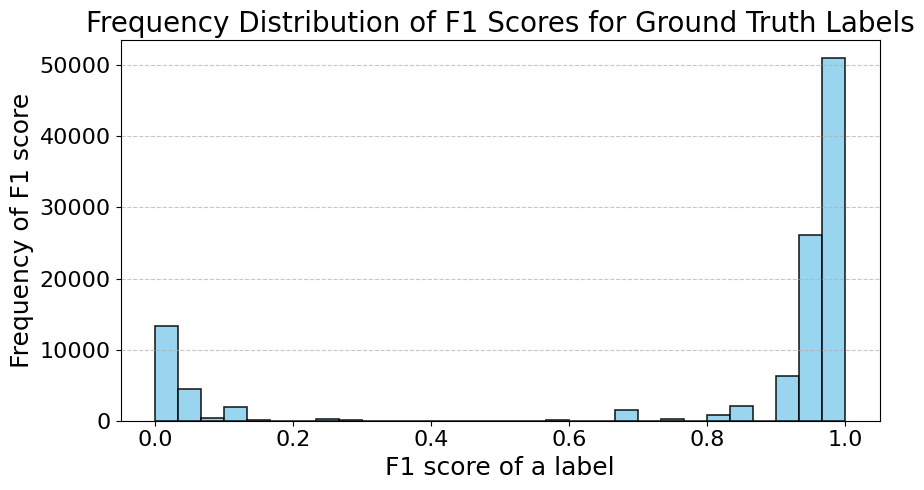

In [39]:
output = []

counts = {}
for parent_key, kv_pairs in results.items():
    for kv_pair, k_hit in kv_pairs.items():
        key, value = kv_pair.split(" || ")
        
        if key not in counts:
            counts[key] = 0
        counts[key] += 1

for k, v in per_category_scores.items():
    TP, FP, FN = v
    if TP == 0:
        print("No matches for: ", k, v)
        pr,rec,f1=0,0,0
    else:
        pr, rec, f1 = TP/(TP+FP), TP/(TP+FN), 2*(TP/(TP+FP))*(TP/(TP+FN))/((TP/(TP+FP))+(TP/(TP+FN)))
    output.append([k, pr, rec, f1])

output = sorted(output, key=lambda p: (p[-1], sum(p[-3:])))[::-1]

f1Scores = []
for k, pr, rec, f1 in output:
    print(k, end=", ")
    print("Precision: ", pr, end=", ")
    print("Recall: ", rec, end=", ")
    print("F1: ", f1)
    f1Scores.extend([f1]*counts[k])

plt.figure(figsize=(9, 5))
plt.hist(f1Scores, bins=30, color="skyblue", edgecolor="black", linewidth=1.2, alpha=0.85)
plt.xlabel("F1 score of a label", fontsize=18)
plt.ylabel("Frequency of F1 score", fontsize=18)
plt.title("Frequency Distribution of F1 Scores for Ground Truth Labels", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [64]:
SRC_GRAPHS = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/allmovie")
with open("/vol/bitbucket/mjh24/IAEA-thesis/data/swde_expanded_dataset/dataset/movie/movie-allmovie(2000).json") as f:
    labels = json.load(f)

graph_folders = sorted([f for f in SRC_GRAPHS.iterdir() if f.is_dir()], key=lambda p: str(p)[-4:])
folder_map = {str(f)[-4:] + ".htm": f for f in graph_folders}

title_results = {}

# assume `data` is the JSON you loaded with json.load(file)
for parent_key in labels:
    titlePrediction = np.load(folder_map[parent_key]/"title_txt.npy")
    print("Loaded: ", parent_key)
    
    pageTitle = labels[parent_key]["topic_entity_name"][0]
    
    for idx, txt in enumerate(titlePrediction):
        if normalise_text(txt) == normalise_text(pageTitle):
            title_results[parent_key] = idx+1
            break
    
    if parent_key not in title_results:
        print(pageTitle, "not found")
        title_results[parent_key] = -1

Loaded:  0000.htm
Loaded:  0001.htm
Loaded:  0002.htm
Loaded:  0003.htm
Loaded:  0004.htm
Loaded:  0005.htm
Loaded:  0006.htm
Loaded:  0007.htm
Loaded:  0008.htm
Loaded:  0009.htm
Loaded:  0010.htm
Loaded:  0011.htm
Loaded:  0012.htm
Loaded:  0013.htm
Loaded:  0014.htm
Loaded:  0015.htm
Loaded:  0016.htm
Loaded:  0017.htm
Loaded:  0018.htm
Loaded:  0019.htm
Loaded:  0020.htm
Loaded:  0021.htm
Loaded:  0022.htm
Loaded:  0023.htm
Loaded:  0024.htm
Loaded:  0025.htm
Loaded:  0026.htm
Loaded:  0027.htm
Loaded:  0028.htm
Loaded:  0029.htm
Loaded:  0030.htm
Loaded:  0031.htm
Loaded:  0032.htm
Loaded:  0033.htm
Loaded:  0034.htm
Loaded:  0035.htm
Loaded:  0036.htm
Loaded:  0037.htm
Loaded:  0038.htm
Loaded:  0039.htm
Loaded:  0040.htm
Loaded:  0041.htm
Loaded:  0042.htm
Loaded:  0043.htm
Loaded:  0044.htm
Loaded:  0045.htm
Loaded:  0046.htm
Loaded:  0047.htm
Loaded:  0048.htm
Loaded:  0049.htm
Loaded:  0050.htm
Loaded:  0051.htm
Loaded:  0052.htm
Loaded:  0053.htm
Loaded:  0054.htm
Loaded:  0

dict_values([5, 7, 1, 33, 12, 7, 21, 15, 6, 2, 10, 45, 9, 29, 11, 9, 13, 11, 5, 9, 26, 42, 1, 2, 3, 9, 12, 2, 24, 1, 17, 9, 16, 16, 14, 29, 1, 10, 15, 9, 16, 1, 2, 21, 15, 19, 11, 5, 1, 2, 12, 1, 14, 16, 2, 6, 9, 2, 17, 12, 5, 10, 2, 1, 5, 48, 18, 4, 9, 15, 2, 5, 3, 8, 3, 1, 9, 2, 2, 29, 5, 7, 20, 4, 1, 10, 2, 4, 35, 1, 41, 1, 8, 10, 15, 3, 18, 24, 10, 12, 1, 6, 24, 18, 4, 1, 1, 9, 5, 5, 8, 1, 2, 1, 3, 2, 2, 14, 6, 15, 2, 26, 1, 28, 2, 2, 13, 7, 17, 2, 2, 1, 3, 19, 6, 2, 20, 26, 19, 19, 4, 17, 23, 2, 19, 2, 4, 20, 11, 27, 27, 2, 7, 16, 2, 2, 8, 23, 13, 1, 2, 14, 33, 14, 8, 1, 1, 21, 1, 10, 2, 18, 20, 16, 17, 11, 17, 2, 10, 16, 30, 2, 8, 45, 14, 1, 1, 1, 10, 18, 28, 15, 11, 2, 30, 17, 2, 9, 11, 12, 2, 2, 19, 3, 11, 6, 3, 3, 2, 10, 14, 2, 27, 1, 3, 1, 3, 12, 18, 19, 2, 3, 3, 40, 2, 36, 5, 4, 8, 2, 20, 4, 13, 2, 2, 1, 51, 8, 6, 17, 8, 1, 15, 11, 5, 1, 7, 2, 12, 10, 11, 2, 2, 8, 21, 27, 1, 7, 10, 24, 11, 2, 13, 12, 1, 21, 14, 22, 2, 13, 14, 1, 3, 2, 7, 10, 36, 22, 2, 9, 2, 8, 12, 20, 2, 26

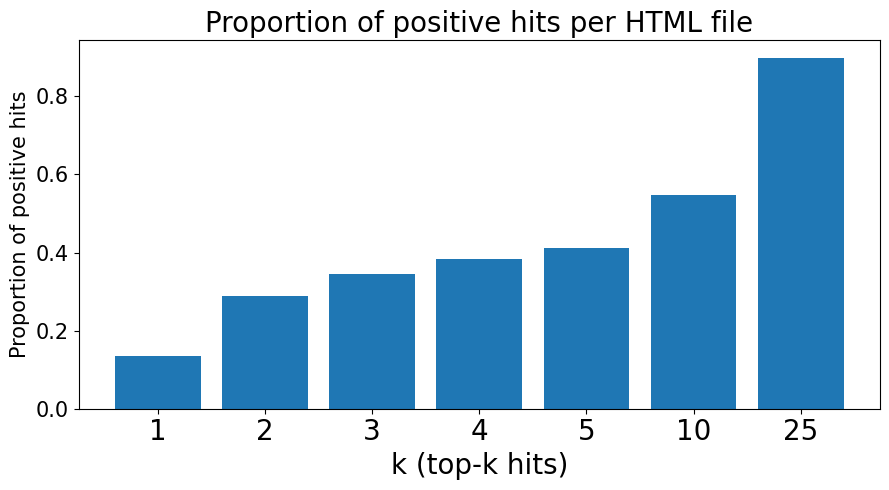

In [68]:
# Count the % correct in a document for the 2000 documents (Recall per document)
percentages = []
ks = [1,2,3,4,5,10,25]
counts = title_results.values()
print(counts)
for k in ks:
    correct = sum(1 for c in counts if 0 < c <= k)
    percentages.append(correct / len(counts))

print(percentages)

plt.figure(figsize=(9, 5))
plt.bar([str(k) for k in ks], percentages)
plt.xlabel("k (top-k hits)", fontdict={"fontsize":20})
plt.ylabel(r"Proportion of positive hits", fontdict={"fontsize":15})
plt.title("Proportion of positive hits per HTML file", fontdict={"fontsize":20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()